In [1]:
import os
import cv2
import time
import math
import random
import segyio
import skimage
import numpy as np
import tensorflow as tf
from scipy import signal
from dotmap import DotMap
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler, Callback


import src.plotter
import src.preprocess
import src.data_loader
from src.customCallbacks import TrainMonitor, cosine_schedule

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')

print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    
    except RuntimeError as e:
        print(e)

2024-05-14 07:52:10.184146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-14 07:52:10.184183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-14 07:52:10.185313: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-14 07:52:10.191433: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-14 07:52:10.833310: W tensorflow/comp

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


2024-05-14 07:52:12.213454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6821 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:17:00.0, compute capability: 7.5


In [2]:
args = DotMap()
args.batch_size = 50
args.epochs = 400
args.input_size = 224
args.mask_ratio = 0.75

### Load Data

In [24]:
dataParihaka = segyio.tools.cube('data/parihaka_full.sgy')
dataParihaka  = src.preprocess.normalize_data(dataParihaka)

X_train = dataParihaka[1:600,:, :]
X_val = dataParihaka[600:800,:, :]
X_test= dataParihaka[800:900, :, :]

print(f"Training samples: {X_train.shape}")
print(f"Validation samples: {X_val.shape}")
print(f"Testing samples: {X_test.shape}")

X_train_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_train, patch_size=args.input_size, 
                                                                                     step=int(args.input_size/2)
                                                                                    )
                                                     )
X_val_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_val, patch_size=args.input_size, 
                                                                                   step=int(args.input_size/2)
                                                                                  )
                                                   )
X_test_patches = src.preprocess.reshape_patches_list(src.preprocess.create_patch_2D(X_test, patch_size=args.input_size, 
                                                                                    step=int(args.input_size/2)
                                                                                   )
                                                    )

X_train_patches = src.preprocess.standarlization_patches(X_train_patches)
X_val_patches = src.preprocess.standarlization_patches(X_val_patches)    
X_test_patches = src.preprocess.standarlization_patches(X_test_patches)

print(f"Training patches samples: {X_train_patches.shape}")
print(f"Validation patches samples: {X_val_patches.shape}")
print(f"Testing patches samples: {X_test_patches.shape}")


batch_train = X_train_patches.shape[0]
idx = np.random.permutation(batch_train)
X_train_patches = X_train_patches[idx]
X_train_patches = X_train_patches[:(batch_train - (batch_train % args.batch_size)), :,:]


batch_val = X_val_patches.shape[0]
idx = np.random.permutation(batch_val)
X_val_patches = X_val_patches[idx]
X_val_patches = X_val_patches[:(batch_val - (batch_val % args.batch_size)),:,:]

batch_test = X_test_patches.shape[0]
idx = np.random.permutation(batch_test)
X_test_patches = X_test_patches[:(batch_test - (batch_test % args.batch_size)),:,:]
    
print(f"Training samples: {X_train_patches.shape}")
print(f"Validation samples: {X_val_patches.shape}")
print(f"Testing samples: {X_test_patches.shape}")

Training samples: (599, 1126, 1168)
Validation samples: (200, 1126, 1168)
Testing samples: (100, 1126, 1168)
Training patches samples: (48519, 224, 224, 1)
Validation patches samples: (16200, 224, 224, 1)
Testing patches samples: (8100, 224, 224, 1)
Training samples: (48500, 224, 224, 1)
Validation samples: (16200, 224, 224, 1)
Testing samples: (8100, 224, 224, 1)


In [4]:
data_generator = src.data_loader.DataLoader(X_train_patches, args.batch_size)
data_generator_val = src.data_loader.DataLoader(X_val_patches, args.batch_size)
test_data = src.data_loader.DataLoader(X_test_patches, args.batch_size)

def gen_data_generator():
    for i in range(data_generator.__len__()):
        yield data_generator.__getitem__(i)

def gen_data_generator_val():
    for i in range(data_generator_val.__len__()):
        yield data_generator_val.__getitem__(i)

        
data_dataset_train =  tf.data.Dataset.from_generator(gen_data_generator, output_signature=(
        tf.TensorSpec(shape=(args.batch_size, 
                             X_train_patches[0].shape[0], 
                             X_train_patches[0].shape[1], 
                             X_train_patches[0].shape[2]), dtype=tf.float32)
))  #according to tf.data.Dataset.from_generator documentation we have to specify output_signature        
        
        
data_dataset_val =  tf.data.Dataset.from_generator(gen_data_generator_val, output_signature=(
        tf.TensorSpec(shape=(args.batch_size, 
                             X_train_patches[0].shape[0],  
                             X_train_patches[0].shape[1],
                             X_train_patches[0].shape[2]), dtype=tf.float32)
))  #according to tf.data.Dataset.from_generator documentation we have to specify output_signature

In [5]:
def Discriminator(img_size,
                  in_chans,
                  ndf
                 ):
    
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, in_chans))

    x = tf.keras.layers.Conv2D(ndf, (4, 4), strides=(2, 2), padding="same")(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(ndf*2, (4, 4), strides=(2, 2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(ndf*4, (4, 4), strides=(2, 2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Conv2D(ndf*8, (4, 4), strides=(2, 2), padding="same")(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid', name="output_layer")(x)

    model = tf.keras.Model(inputs, x, name="discriminator")
    model.summary()
    
    return model

In [6]:
def blocks(embed_dim,
            num_heads,
            mlp_ratio,
            depth
           ):
    
    inputs = tf.keras.layers.Input((None, embed_dim))
    x = inputs
    
    for _ in range(depth):

        # Layer normalization 1.
                # Create a multi-head attention layer.
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        
        att = tf.keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=(inputs.shape[-1] // num_heads), dropout=0.0
        )(x, x)

        # Skip connection 1.
        x = x + att

        # Layer normalization 2.
        y = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)
        y = tf.keras.layers.Dense(int(embed_dim * mlp_ratio), activation='gelu')(y)
        y = tf.keras.layers.Dense(embed_dim, activation='linear')(y)
        y = tf.keras.layers.Dropout(0.0)(y)

        # Skip connection 2.
        x = x + y
    

    model = tf.keras.Model(inputs, x, name="transformer_block")
    
    return model

In [7]:
from src.vision_transformer import PatchEmbed, Decoder, Encoder
from src.pos_embed import get_2d_sincos_pos_embed
from src.util import torch_gather, tf_function, tf_patchify, tf_unpatchify
import numpy as np

class MaskedAutoencoderGan(tf.keras.Model):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=1,
                 embed_dim=384, depth=12, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., mask_ratio=0.75, batch_size=8):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.channel = in_chans
        self.batch_size = batch_size
        self.patch_size = patch_size
        
        self.patch_embed = PatchEmbed(img_size, 
                                      patch_size, 
                                      in_chans, 
                                      embed_dim
                                     )
        
        self.num_patches = self.patch_embed.num_patches

        
        self.cls_token = tf.Variable(name="cls_token",
                                     initial_value = tf.random.normal(
                                         shape=(1, 1, embed_dim), dtype='float32'), 
                                     trainable=True
                                    )
        self.pos_embed = tf.Variable(name="pos_embed", 
                                     initial_value=tf.zeros((1, self.num_patches + 1, embed_dim)), 
                                     trainable=True)  # fixed sin-cos embedding


        self.encoder_block = blocks(embed_dim,
                                     num_heads,
                                     mlp_ratio,
                                     depth
                                     )

        self.norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics        
        self.mask_token = tf.Variable(name="mask_token",
                                     initial_value = tf.random.normal(
                                         shape=(1, 1, decoder_embed_dim), dtype='float32'), 
                                     trainable=True
                                    )

        self.decoder_pos_embed = tf.Variable(name="decoder_pos_embed",
                                             initial_value=tf.zeros((1, self.num_patches + 1, decoder_embed_dim))
                                            )  # fixed sin-cos embedding

        self.decoder_blocks = blocks(decoder_embed_dim,
                                     decoder_num_heads,
                                     mlp_ratio,
                                     decoder_depth
                                     )


        self.decoder_embed = tf.keras.layers.Dense(decoder_embed_dim, 
                                                   activation='linear',
                                                   use_bias=True)
        
        self.decoder_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.decoder_pred = tf.keras.layers.Dense(units=self.patch_size**2*self.channel, 
                                                  activation="linear", 
                                                  use_bias=True,
                                                  name="output_layer")
           

        self.mask_ratio = mask_ratio
        
        self.discriminator = Discriminator(img_size, in_chans, 64)
                                                            
         
        # --------------------------------------------------------------------------

        self.initialize_weights()
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.d_loss_tracker = tf.keras.metrics.Mean(name="d_loss")
        self.ssim_tracker = tf.keras.metrics.Mean(name="ssim_metric")
        self.penalty_loss_tracker = tf.keras.metrics.Mean(name="penalty_loss")
        self.lambda_tracker = tf.keras.metrics.Mean(name="lambda")
        

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        self.pos_embed = tf.expand_dims(get_2d_sincos_pos_embed(self.pos_embed.shape[-1],
                               int(self.patch_embed.num_patches**.5), cls_token=True
                              ), axis=0)
                
        
        self.decoder_pos_embed = tf.expand_dims(get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1],
                                       int(self.patch_embed.num_patches**.5), cls_token=True
                                      ), axis=0)
        
    
    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """   
        return tf_patchify(self.patch_embed.patch_size[0], imgs, self.channel)

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """           
        return tf_unpatchify(self.patch_embed.patch_size[0], x, self.channel)
    
    def random_masking(self, x, mask_ratio):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        N, L, D = x.shape  # batch, length, dim
        len_keep = int(L * (1 - mask_ratio))
        
        if N != None:
            self.batch_size = N 
    
        noise = tf.random.normal([self.batch_size, L])
    
        # sort noise for each sample
        ids_shuffle = tf.argsort(noise, axis=1)  # ascend: small is keep, large is remove
        ids_restore = tf.argsort(ids_shuffle, axis=1)

        # keep the first subset
        ids_keep = ids_shuffle[:, :len_keep]
        ids_keep = tf.expand_dims(ids_keep, axis=-1)
        ids_keep = tf.repeat(ids_keep, repeats=D, axis=-1)

        x_masked = torch_gather(x, ids_keep, 1)
        
        # generate the binary mask: 0 is keep, 1 is remove
        mask = tf.ones([self.batch_size, L])
        #mask[:, :len_keep] = 0

        mask = tf_function(mask, len_keep)

        # unshuffle to get the binary mask
        mask = torch_gather(mask, ids_restore, 1)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]
        
        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = tf.broadcast_to(cls_token, [tf.shape(x)[0], cls_token.shape[1], cls_token.shape[2]])
        
        x = tf.concat((cls_tokens, x), axis=1)

        # apply Transformer blocks
        x = self.encoder_block(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)
        
        # append mask tokens to sequence
        mask_tokens = tf.repeat(self.mask_token, ids_restore.shape[1] + 1 - x.shape[1], axis=1)
        mask_tokens = tf.broadcast_to(mask_tokens, [x.shape[0], mask_tokens.shape[1], mask_tokens.shape[2]])

        
        #mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = tf.concat([x[:, 1:, :], mask_tokens], axis=1)  # no cls token
        
        ids_restore = tf.expand_dims(ids_restore, axis=-1)
        ids_restore = tf.repeat(ids_restore, repeats=x.shape[2], axis=-1)
        
        x_ = torch_gather(x_, ids_restore, 1)  # unshuffle
        x = tf.concat([x[:, :1, :], x_], axis=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        x = self.decoder_blocks(x)
        x = self.decoder_norm(x)
        x = self.decoder_pred(x)
        # remove cls token
        x = x[:, 1:, :]

        return x
    
    def compile(self, d_optimizer, optimizer, loss_d, loss_fn, penalty_loss):
            super().compile()
            self.d_optimizer = d_optimizer
            self.optimizer = optimizer
            self.loss_d = loss_d
            self.loss_fn = loss_fn
            self.penalty_loss = penalty_loss
            
    def train_step(self, imgs):
                 
        with tf.GradientTape() as tape, tf.GradientTape() as disc_tape:
            latent, mask, ids_restore = self.forward_encoder(imgs, 
                                                             self.mask_ratio)
            pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
            
            target = self.patchify(imgs)
            loss = self.loss_fn(target,
                                pred, 
                                mask)
        
            real_output = self.discriminator(imgs)
            fake_output = self.discriminator(self.unpatchify(pred))
            
            d_loss = self.loss_d(real_output, 
                                 fake_output)
            
            additional_loss = self.penalty_loss(fake_output)

            ssim_metric = tf_ssim_metrics(imgs, self.unpatchify(pred))
            
                
            Lambda = tf.nn.dropout(0.2, 0.5)
            combined_loss = loss + Lambda * additional_loss

            
            
        grads = disc_tape.gradient(d_loss, self.discriminator.trainable_variables)
        #del disc_tape
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_variables)
        )
        
            # Apply gradients.
        train_vars = [
            self.norm.trainable_variables,
            self.decoder_norm.trainable_variables,
            self.decoder_pred.trainable_variables,
            self.encoder_block.trainable_variables,
            self.decoder_blocks.trainable_variables,
            self.decoder_embed.trainable_variables,
            self.patch_embed.trainable_variables,
        ]
        
        grads = tape.gradient(combined_loss, train_vars)

        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        
        self.loss_tracker.update_state(combined_loss)
        self.d_loss_tracker.update_state(d_loss)
        self.ssim_tracker.update_state(ssim_metric)
        self.penalty_loss_tracker.update_state(additional_loss)
        self.lambda_tracker.update_state(Lambda)
        
        return {"d_loss": self.d_loss_tracker.result(),
                "loss": self.loss_tracker.result(),
               "penalty_loss": self.penalty_loss_tracker.result(),
               "Lambda": self.lambda_tracker.result(),
               "ssim_metric": self.ssim_tracker.result()
               }

    def test_step(self, imgs):


        latent, mask, ids_restore = self.forward_encoder(imgs, 
                                                         self.mask_ratio
                                                        )
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        
        
        loss = self.loss_fn(self.patchify(imgs),
                            pred, 
                            mask)
    
        real_output = self.discriminator(imgs)
        fake_output = self.discriminator(self.unpatchify(pred))
        
        d_loss = self.loss_d(real_output, 
                             fake_output)
        
        additional_loss = self.penalty_loss(fake_output)
        ssim_metric = tf_ssim_metrics(imgs, self.unpatchify(pred))
        
            
        Lambda = tf.nn.dropout(0.2, 0.5)
        combined_loss = loss + Lambda * additional_loss
        
        self.loss_tracker.update_state(combined_loss)
        self.d_loss_tracker.update_state(d_loss)
        self.lambda_tracker.update_state(Lambda)
        self.ssim_tracker.update_state(ssim_metric)
        self.penalty_loss_tracker.update_state(additional_loss)

        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {"d_loss": self.d_loss_tracker.result(),
                "loss": self.loss_tracker.result(),
                "penalty_loss": self.penalty_loss_tracker.result(),
                "Lambda": self.lambda_tracker.result(),
                "ssim_metric": self.ssim_tracker.result()
               }

In [8]:
def SSIM(real_data,
         fake_data
        ):
    
    K = [0.01, 0.03]
    L = 1
    kernelX = cv2.getGaussianKernel(11, 1.5)
    window = kernelX * kernelX.T
     
    batch, M, N, _= real_data.shape

    C1 = (K[0]*L)**2
    C2 = (K[1]*L)**2
    mssim = []
    for i in range(batch):

        img1 = np.squeeze(real_data[i], axis=-1)
        img2 = np.squeeze(fake_data[i], axis=-1)
     
        mu1 = signal.convolve2d(img1, window, 'valid')
        mu2 = signal.convolve2d(img2, window, 'valid')
        
        mu1_sq = mu1*mu1
        mu2_sq = mu2*mu2
        mu1_mu2 = mu1*mu2
        
        
        sigma1_sq = signal.convolve2d(img1*img1, window, 'valid') - mu1_sq
        sigma2_sq = signal.convolve2d(img2*img2, window, 'valid') - mu2_sq
        sigma12 = signal.convolve2d(img1*img2, window, 'valid') - mu1_mu2
       
        ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))
        mssim.append(np.mean(ssim_map))

    return np.mean(mssim, dtype=np.float32)


def tf_ssim_metrics(real_data, fake_data):
    ssim_metric = tf.numpy_function(SSIM, [real_data, fake_data], tf.float32)
    return ssim_metric

In [9]:
model = MaskedAutoencoderGan(img_size=224, patch_size=16, in_chans=1,
                          embed_dim=192, depth=4, num_heads=6,
                          decoder_embed_dim=256, decoder_depth=3, decoder_num_heads=16,
                          mlp_ratio=4., mask_ratio=args.mask_ratio, batch_size=args.batch_size)

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 64)      1088      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 112, 112, 64)      0         
                                                                 
 dropout_7 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 56, 56, 128)       0         
                                                                 
 dropout_8 (Dropout)         (None, 56, 56, 128)     

In [10]:
dt = time.localtime()

strinstante = "%02d-%02d-%04d-%02d-%02d" % (dt.tm_year, dt.tm_mon, dt.tm_mday, dt.tm_hour, dt.tm_min)

out_directory = 'pretrain' + "/checkpoint" + strinstante 

if not os.path.exists(out_directory):
    os.makedirs(out_directory)
    
model_save_name = out_directory + "/checkpoint_test_" + strinstante + ".cpk"

train_callbacks = [TrainMonitor(test_data, epoch_interval=5),
                  tf.keras.callbacks.EarlyStopping(monitor="val_ssim_metric", 
                                                   patience=20, 
                                                   mode='max'),
                   LearningRateScheduler(cosine_schedule(base_lr=1e-3, 
                                      total_steps=args.epochs, 
                                      warmup_steps=20)),
                   
                   tf.keras.callbacks.ModelCheckpoint(model_save_name, 
                                               save_best_only=True, 
                                               save_weights_only=True, 
                                               monitor="val_loss", 
                                               verbose=1
                                            ),
                  ]


Idx chosen: 4


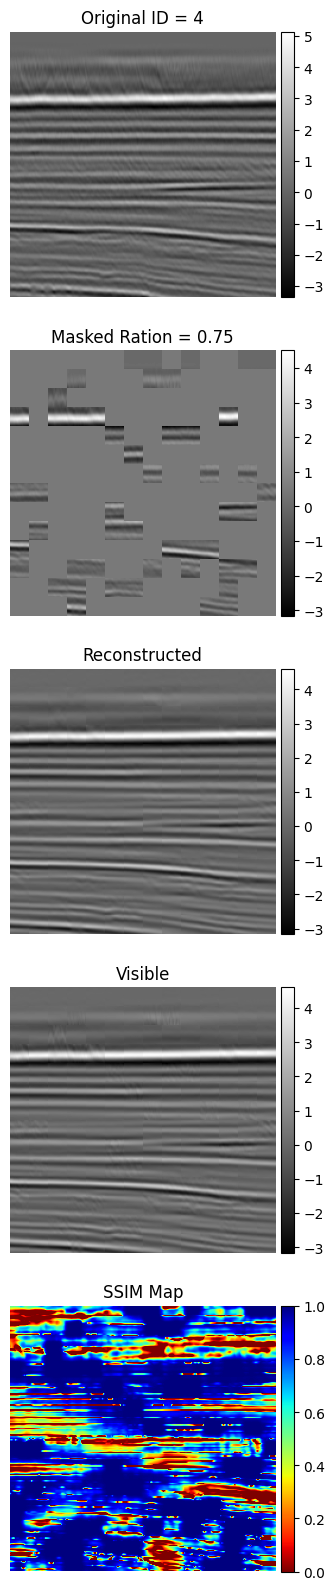

In [25]:
src.plotter.plot_result(next(iter(test_data)),
                    model,
                    model.mask_ratio
                               )

In [9]:
def discriminator_loss(real_output, fake_output):
    real_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real_output), logits=real_output)
    fake_loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake_output), logits=fake_output)
    total_loss = tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss)
    return total_loss

def penalty_loss(fake_output):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake_output), logits=fake_output))

def custom_loss(y_true, y_pred, mask):  
    loss = tf.reduce_mean(tf.square(y_true - y_pred))
    loss = tf.math.reduce_sum((loss * mask)) / tf.math.reduce_sum(mask)
    
    return loss

In [ ]:
# Compile and pretrain the model.
model.compile(
    d_optimizer=tf.keras.optimizers.Adam(), 
    optimizer=tf.keras.optimizers.AdamW(), 
    loss_d=discriminator_loss,
    loss_fn=custom_loss, 
    penalty_loss=penalty_loss
    )


history = model.fit(data_dataset_train, 
                    epochs=args.epochs, 
                    shuffle=True, 
                    validation_data=data_dataset_val, 
                    callbacks=train_callbacks,
)

2024-05-10 17:34:42.971611: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-10 17:34:42.971649: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-10 17:34:42.971687: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-10 17:34:42.971721: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.

Epoch 1/400


2024-05-10 17:34:52.705855: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-05-10 17:34:52.801282: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-10 17:34:52.804966: W external/local_xla/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-05-10 17:34:52.955152: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-05-10 17:34:52.957615: W tenso

      1/Unknown - 23s 23s/step - d_loss: 1.4493 - loss: 1.8711 - penalty_loss: 0.4728 - Lambda: 0.0000e+00 - ssim_metric: 0.0131

2024-05-10 17:35:06.662437: E external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 9.1.108, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.



    260/Unknown - 720s 3s/step - d_loss: 1.0185 - loss: 1.0617 - penalty_loss: 0.6902 - Lambda: 0.2160 - ssim_metric: 0.0911

In [37]:
model_save_name = 'pretrain/checkpoint2024-05-0010-17-34/checkpoint_test_2024-05-0010-17-34.cpk'

In [38]:
model = MaskedAutoencoderGan(img_size=224, patch_size=16, in_chans=1,
                          embed_dim=192, depth=4, num_heads=6,
                          decoder_embed_dim=256, decoder_depth=3, decoder_num_heads=16,
                          mlp_ratio=4., mask_ratio=args.mask_ratio, batch_size=args.batch_size)

model.built = True
model.load_weights(model_save_name)
#model.encoder_block.save_weights(out_directory + '/checkpoint_test_encoder.h5')
model.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 112, 112, 64)      1088      
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 112, 112, 64)      0         
                                                                 
 dropout_62 (Dropout)        (None, 112, 112, 64)      0         
                                                                 
 conv2d_21 (Conv2D)          (None, 56, 56, 128)       131200    
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 56, 56, 128)       0         
                                                                 
 dropout_63 (Dropout)        (None, 56, 56, 128)     


Idx chosen: 22


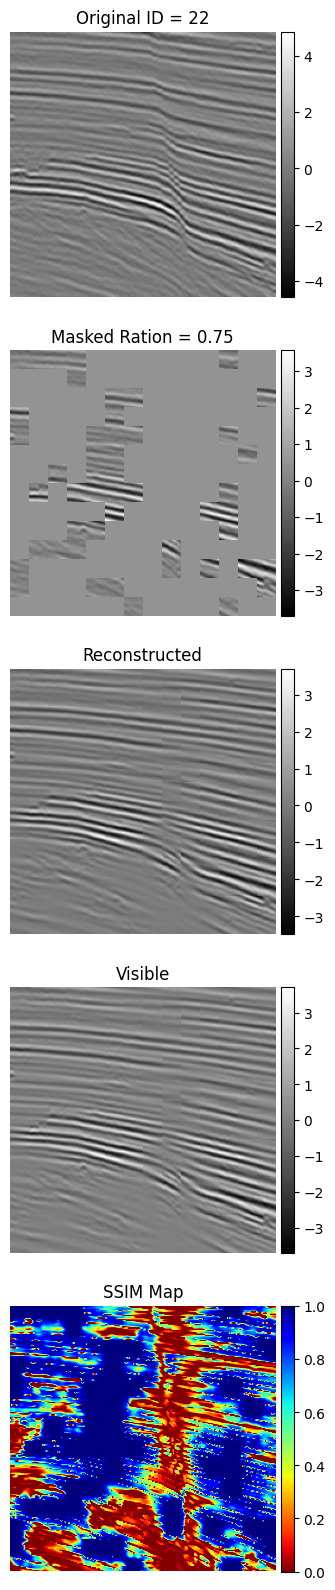

In [39]:
test_images = next(iter(test_data))
x = test_images

src.plotter.plot_result(test_images,
                    model,
                    model.mask_ratio
                               )

In [40]:
imgs = test_images
latent, mask, ids_restore = model.forward_encoder(imgs, 
                                                 model.mask_ratio
                                                )
pred = model.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]


loss = custom_loss(model.patchify(imgs),
                    pred, 
                    mask)

real_output = model.discriminator(imgs)
fake_output = model.discriminator(model.unpatchify(pred))

d_loss = discriminator_loss(real_output, 
                     fake_output)

additional_loss = penalty_loss(fake_output)
ssim_metric = tf_ssim_metrics(imgs, model.unpatchify(pred))

    
Lambda = tf.nn.dropout(0.2, 0.5)
combined_loss = loss + Lambda * additional_loss

In [41]:
ssim_metric

<tf.Tensor: shape=(), dtype=float32, numpy=0.60070103>